In [1]:
import pandas as pd
import numpy as np
import torch
import re
import json
import spacy
import contractions
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config

# 1: Load the Data

In [2]:
# Load the JSON file into a Python dictionary
with open('data/dev-v1.1.json') as f:
    data_d = json.load(f)
    
with open('data/train-v1.1.json') as f:
    data_t = json.load(f)

# Extract the 'paragraphs' from 'data' in JSON
paragraphs_d = data_d['data'][0]['paragraphs']
paragraphs_t = data_t['data'][0]['paragraphs']

# Normalize the JSON data to a DataFrame
df_dev = pd.json_normalize(paragraphs_d, record_path=['qas'], meta=['context'])
df_train = pd.json_normalize(paragraphs_t, record_path=['qas'], meta=['context'])

# 2: Check Basic Information

In [3]:
print(df_dev.info())
print(df_dev.describe())
print(df_dev.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   answers   810 non-null    object
 1   question  810 non-null    object
 2   id        810 non-null    object
 3   context   810 non-null    object
dtypes: object(4)
memory usage: 25.4+ KB
None
                                                  answers  \
count                                                 810   
unique                                                571   
top     [{'answer_start': 177, 'text': 'Denver Broncos...   
freq                                                    7   

                                        question                        id  \
count                                        810                       810   
unique                                       800                       810   
top     How old was Newton during Super Bowl 50?  56be4db0acb8001400a502ec   
freq

In [4]:
print(df_train.info())
print(df_train.describe())
print(df_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   answers   269 non-null    object
 1   question  269 non-null    object
 2   id        269 non-null    object
 3   context   269 non-null    object
dtypes: object(4)
memory usage: 8.5+ KB
None
                                                  answers  \
count                                                 269   
unique                                                268   
top     [{'answer_start': 11, 'text': 'Father John Fra...   
freq                                                    2   

                                                 question  \
count                                                 269   
unique                                                269   
top     To whom did the Virgin Mary allegedly appear i...   
freq                                                    1   

           

The DataFrames df_dev and df_train have columns such as question, context, answers, and id. 
For a generative chatbot, the key components are:

1. context (the background information)
2. question (the prompts or user queries)
3. answers (responses that provide relevant data)

# 3.  Data Quality Checks:

In [5]:
# Check for missing values in columns like context, question, and answers

print(df_dev.isnull().sum())
print(df_train.isnull().sum())

answers     0
question    0
id          0
context     0
dtype: int64
answers     0
question    0
id          0
context     0
dtype: int64


# 4: Data Preprocessing and Tokenization

## Handle Nested Answers

In [6]:
# The answers column contains a list of dictionaries, so extract the text for easier processing

df_dev['answer_text'] = df_dev['answers'].apply(lambda x: x[0]['text'] if len(x) > 0 else '')
df_train['answer_text'] = df_train['answers'].apply(lambda x: x[0]['text'] if len(x) > 0 else '')


## Combine Context and Question

In [7]:
# To create a prompt-response pair, combine the context and question into a single prompt

df_dev['input_text'] = df_dev['context'] + " " + df_dev['question']
df_dev['target_text'] = df_dev['answer_text']

df_train['input_text'] = df_train['context'] + " " + df_train['question']
df_train['target_text'] = df_train['answer_text']


## Tokenization

In [8]:
nlp = spacy.load('en_core_web_lg')

# Load the tokenizer for distilgpt2
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')

def calculate_token_length(text):
    return len(tokenizer.encode(text))

df_dev['token_length'] = df_dev.apply(lambda row: calculate_token_length(row['input_text'] + ' ' + row['target_text']), axis=1)
df_train['token_length'] = df_train.apply(lambda row: calculate_token_length(row['input_text'] + ' ' + row['target_text']), axis=1)

/Users/jabalishah/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# 5. Exploratory Data Analysis

## Token Length Statistics

In [9]:
print("Dev Token Length Statistics:")
print(df_dev['token_length'].describe())

print("\nTrain Token Length Statistics:")
print(df_train['token_length'].describe())

Dev Token Length Statistics:
count    810.000000
mean     151.666667
std       77.160277
min       42.000000
25%       92.000000
50%      142.000000
75%      194.000000
max      439.000000
Name: token_length, dtype: float64

Train Token Length Statistics:
count    269.000000
mean     206.338290
std       70.048869
min      119.000000
25%      148.000000
50%      186.000000
75%      255.000000
max      394.000000
Name: token_length, dtype: float64


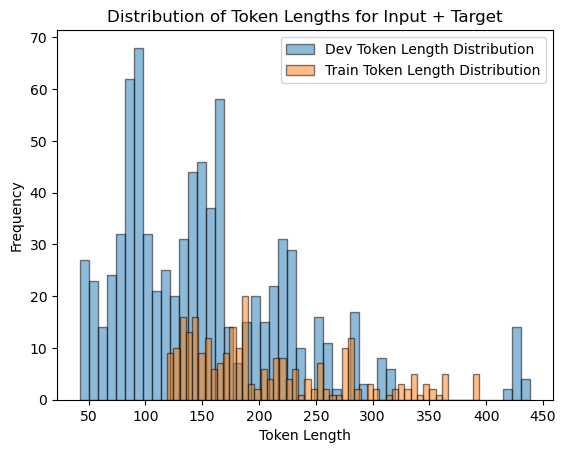

In [10]:
plt.hist(df_dev['token_length'], bins=50, alpha=0.5, label='Dev Token Length Distribution', edgecolor='black')
plt.hist(df_train['token_length'], bins=50, alpha=0.5, label='Train Token Length Distribution', edgecolor='black')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths for Input + Target')
plt.legend()
plt.show()

## Input Length Categories

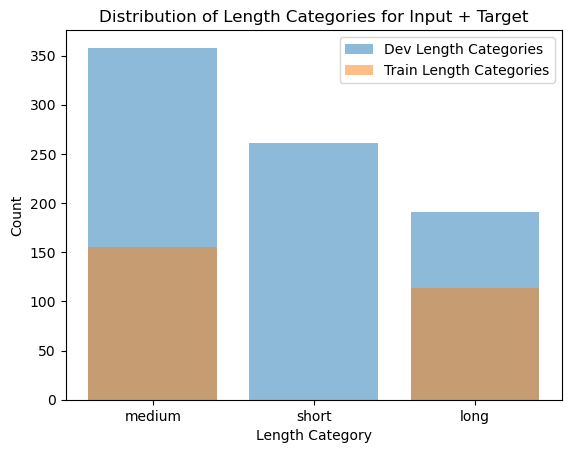

In [12]:
# Distribution of Input Length Categories
def categorize_length(length):
    if length < 100:
        return 'short'
    elif length < 200:
        return 'medium'
    else:
        return 'long'

df_train['length_category'] = df_train['token_length'].apply(categorize_length)
df_dev['length_category'] = df_dev['token_length'].apply(categorize_length)

# Plotting length category distribution
length_category_counts_train = df_train['length_category'].value_counts()
length_category_counts_dev = df_dev['length_category'].value_counts()

plt.bar(length_category_counts_dev.index, length_category_counts_dev.values, alpha=0.5, label='Dev Length Categories')
plt.bar(length_category_counts_train.index, length_category_counts_train.values, alpha=0.5, label='Train Length Categories')
plt.xlabel('Length Category')
plt.ylabel('Count')
plt.title('Distribution of Length Categories for Input + Target')
plt.legend()
plt.show()

## Token Overlap Analysis

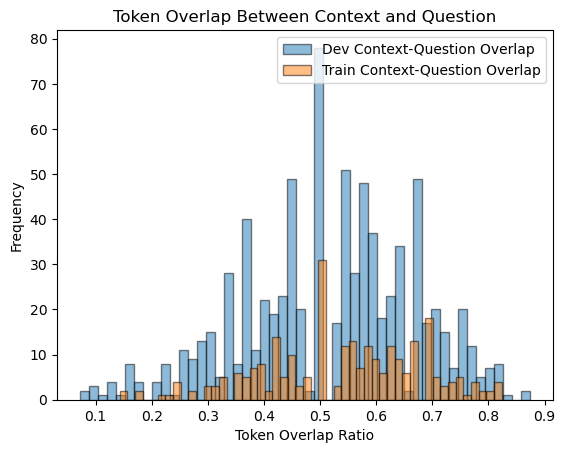

In [13]:
# Token Overlap Analysis
def calculate_overlap(context, question):
    context_tokens = set(tokenizer.tokenize(context))
    question_tokens = set(tokenizer.tokenize(question))
    return len(context_tokens.intersection(question_tokens)) / len(question_tokens)

df_train['context_question_overlap'] = df_train.apply(lambda row: calculate_overlap(row['context'], row['question']), axis=1)
df_dev['context_question_overlap'] = df_dev.apply(lambda row: calculate_overlap(row['context'], row['question']), axis=1)

# Plotting token overlap distribution
plt.hist(df_dev['context_question_overlap'], bins=50, alpha=0.5, label='Dev Context-Question Overlap', edgecolor='black')
plt.hist(df_train['context_question_overlap'], bins=50, alpha=0.5, label='Train Context-Question Overlap', edgecolor='black')
plt.xlabel('Token Overlap Ratio')
plt.ylabel('Frequency')
plt.title('Token Overlap Between Context and Question')
plt.legend()
plt.show()

## N-gram Analysis

In [14]:
# N-gram Analysis
from collections import Counter

def get_ngrams(text, n=2):
    tokens = tokenizer.tokenize(text)
    return zip(*[tokens[i:] for i in range(n)])

bigram_counter_dev = Counter()
for input_text in df_dev['input_text']:
    bigram_counter_dev.update(get_ngrams(input_text, n=2))

print("Most common bigrams in dev data:")
print(bigram_counter_dev.most_common(10))

bigram_counter_train = Counter()
for input_text in df_train['input_text']:
    bigram_counter_train.update(get_ngrams(input_text, n=2))

print("Most common bigrams in training data:")
print(bigram_counter_train.most_common(10))

Most common bigrams in dev data:
[(('ĠSuper', 'ĠBowl'), 1880), (('Ġin', 'Ġthe'), 755), ((',', 'Ġand'), 671), (('Ġof', 'Ġthe'), 571), (('.', 'ĠThe'), 532), ((',', 'Ġthe'), 508), (('Ġthe', 'Ġgame'), 494), (('-', 'yard'), 442), (('ĠBowl', 'Ġ50'), 384), (('Ġwas', 'Ġthe'), 334)]
Most common bigrams in training data:
[(('ĠNotre', 'ĠDame'), 641), (('Ġof', 'Ġthe'), 461), (('.', 'ĠThe'), 404), ((',', 'Ġand'), 395), (('Ġin', 'Ġthe'), 376), ((',', 'Ġthe'), 226), (('Ġthe', 'Ġuniversity'), 165), (('.', 'ĠIn'), 128), (('Ġand', 'Ġthe'), 121), (('Ġat', 'ĠNotre'), 120)]


## Outliers in Token Length

In [15]:
# Find Outliers in Token Length
q1_train = df_train['token_length'].quantile(0.25)
q3_train = df_train['token_length'].quantile(0.75)
iqr_train = q3_train - q1_train

lower_bound_train = q1_train - 1.5 * iqr_train
upper_bound_train = q3_train + 1.5 * iqr_train

outliers_train = df_train[(df_train['token_length'] < lower_bound_train) | (df_train['token_length'] > upper_bound_train)]
print(f"Number of outliers in training data: {len(outliers_train)}")

q1_dev = df_dev['token_length'].quantile(0.25)
q3_dev = df_dev['token_length'].quantile(0.75)
iqr_dev = q3_dev - q1_dev

lower_bound_dev = q1_dev - 1.5 * iqr_dev
upper_bound_dev = q3_dev + 1.5 * iqr_dev

outliers_dev = df_dev[(df_dev['token_length'] < lower_bound_dev) | (df_dev['token_length'] > upper_bound_dev)]
print(f"Number of outliers in development data: {len(outliers_dev)}")

Number of outliers in training data: 0
Number of outliers in development data: 20
